# LIANA x Tensor-c2c Python quickstart

This tutorial provides an abbreviated version of Tutorials 01-06 in order to give a quick overview of the pipeline to go from a raw counts matrix to downstream cell-cell communication (CCC) analyses. By combining LIANA and Tensor-cell2cell, we get a general framework that can robustly incorporate many existing CCC inference tools, ultimately retriving consensus communication scores for any sample and analyzing all those samples together to identify context-dependent communication programs.  

## Set up

### Enabling GPU use

If you are using a NVIDIA GPU, after installing PyTorch with CUDA enabled, specify `use_gpu = True`. Otherwise, `use_gpu = False`.

In [1]:
use_gpu = True

if use_gpu:
    import tensorly as tl
    tl.set_backend('pytorch')

/home/hratch/miniconda3/envs/ccc_protocols/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Libraries

In [2]:
import cell2cell as c2c
import liana as li

import pandas as pd
import decoupler as dc
import scanpy as sc

import matplotlib.pyplot as plt
%matplotlib inline
import plotnine as p9
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Directories

In [4]:
data_folder = '../../data/quickstart/' # '/data/hratch/ccc_protocols/interim/' # #<-uncomment in final
output_folder = '../../data/quickstart/outputs'
c2c.io.directories.create_directory(data_folder)
c2c.io.directories.create_directory(output_folder)

../../data/quickstart/ already exists.
../../data/quickstart/outputs already exists.


### Loading Data

We will use a [BALF COVID dataset](https://doi.org/10.1038/s41591-020-0901-9), which contains 12 samples associated with "Healthy Control", "Moderate", or "Severe" COVID contexts. We can load this data using cell2cell:

In [5]:
adata = c2c.datasets.balf_covid()

## 1) Preprocess Expression

We use the popular single-cell analysis software [scanpy](https://scanpy.readthedocs.io/en/stable/) to preprocess our raw UMI counts. To improve CCC inference, the main goals for preprocessing are 1) excluding noisy or low-quality genes and cells and 2) transforming the data in a manner that CCC tools can handle. Typically, CCC tools expect log- and library-normalized counts (e.g. log(1+CPM)). Furthermore, these tools, as well as Tensor-cell2cell, expect non-negative counts. 

We do not include a batch correction step as Tensor-cell2cell can get robust decomposition results without this; however, we have extensive analysis and discuss regarding this topic in [Supplementary Tutorial 01](../S1_Batch_Correction.ipynb)

### Filtering

This helps remove noise due to low quality measurements. 

Let's start with removing non-informative cells and genes:

In [6]:
# basic filters
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

We can also remove droplets with high mitochondrial content:

In [7]:
# filter low quality cells with standard QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, 
                           qc_vars=['mt'], 
                           percent_top=None, 
                           log1p=False, 
                           inplace=True)
adata = adata[adata.obs.pct_counts_mt < 15, :]

Next, we remove droplets taht potentially could have more than one single cell (doublets):

In [8]:
adata = adata[adata.obs.n_genes < 5500, :] 

### Normalization

Library-normalize and log-transform the data:

In [9]:
# save the raw counts to a layer
adata.layers["counts"] = adata.X.copy()

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Let's see what our data looks like:

In [10]:
adata.obs.head()

,sample,sample_new,group,disease,hasnCoV,cluster,celltype,condition,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCACAGCTACAT_3,C100,HC3,HC,N,N,27.0,B,Control,1377,1376,3123.0,287.0,9.189881
AAACCCATCCACGGGT_3,C100,HC3,HC,N,N,23.0,Macrophages,Control,836,835,1429.0,13.0,0.909727
AAACCCATCCCATTCG_3,C100,HC3,HC,N,N,6.0,T,Control,1105,1105,2342.0,148.0,6.319385
AAACGAACAAACAGGC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control,4530,4530,31378.0,3132.0,9.981516
AAACGAAGTCGCACAC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control,3409,3409,12767.0,659.0,5.161745


Key columns include:

`sample_new`: the sample from which a cell was derived

`condition`: the disease context of a given sample (one of `Control`, `Moderate COVID-19`, or `Severe COVID-19`)

`celltype`: the annotated cell types between which communication will be inferred

## 2) Infer Communication Scores

LIANA provides a general framework that can implement multiple CCC resources (i.e., ligand-receptor interaction databases)  and methods. We will use LIANA to iteratively infer communication in each sample, calculating a consensus score across different tools. 

First, let's see the available methods that LIANA can run:

In [11]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


Let's also see the resources available to LIANA:

In [12]:
liana_resources = li.resource.show_resources()
print(*liana_resources, sep = ', ')

baccin2019, cellcall, cellchatdb, cellinker, cellphonedb, celltalkdb, connectomedb2020, consensus, embrace, guide2pharma, hpmr, icellnet, italk, kirouac2010, lrdb, mouseconsensus, ramilowski2015


For each sample, we will run each method available to LIANA and further aggregate these results into a consensus rank score. All methods will be run on LIANA's consensus resource. These steps can be performed using the `rank_aggregate` function. 

The parameters that we will use are the following:
- `groupby` is the column in the `meta` dataframe that contains the cell groups
- `use_raw` is a boolean that indicates whether to use the `.raw` attribute of the `adata` object, or the `.X`. attribute. Since most CCC tools expect library- and log-normalized data, we will use the `.X` attribute. 
- `expr_prop` is the proportion of cells that need to express a ligand-receptor for it to be considered in the CCC calculations

Let's select LIANA's "Consensus" resource:

In [13]:
lr_pairs = li.resource.select_resource('consensus')

Next, we can run LIANA on each sample using the six default methods (CellPhoneDBv2, CellChat, SingleCellSignalR, NATMI, Connectome, log2FC):

In [14]:
li.mt.rank_aggregate.by_sample(adata, 
                               sample_key='sample_new', 
                               groupby='celltype', 
                               resource_name = 'consensus',
                               expr_prop=0.1, # must be expressed in expr_prop fraction of cells
                               min_cells = 5,
                               n_perms = 100, 
                               use_raw = False, # run on log- and library-normalized counts
                               verbose = True, 
                               inplace = True
                              )

Now running: S6: 100%|██████████████████████████| 12/12 [03:59<00:00, 19.96s/it]


The results are stored in `adata.uns['liana_res']`. Let's see what they look like:

In [15]:
adata.uns['liana_res'].head()

,sample_new,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,steady_rank,specificity_rank,magnitude_rank
0,HC1,Macrophages,NK,B2M,CD3D,3.410504,0.0,8.059612,1.300556,1.397895,0.083273,0.961040,0.221495,0.0,0.000602,0.003713,1.698996e-09
1,HC1,T,NK,B2M,CD3D,3.410586,0.0,8.059861,1.300856,1.272266,0.083276,0.961041,0.221213,0.0,0.000602,0.003713,6.256593e-09
2,HC1,NK,NK,B2M,CD3D,3.264099,0.0,7.614378,0.790913,1.113901,0.078673,0.959963,0.216816,0.0,0.001968,0.006245,2.653267e-08
3,HC1,T,NK,B2M,KLRD1,3.297900,0.0,6.865250,6.960920,1.244892,0.171293,0.957924,0.214586,0.0,0.000013,0.000092,9.767878e-08
4,HC1,Macrophages,NK,B2M,KLRD1,3.297818,0.0,6.865037,6.960620,1.370520,0.171288,0.957924,0.214861,0.0,0.000013,0.000092,1.086199e-07


This dataframe provides the results from running each method, as well as the consensus scores across the methods. In our case, we are interested in the magnitude consensus scored denoted by the `'magnitude_rank'` column. Let's export it in case we want to access it later:

In [16]:
adata.uns['liana_res'].to_csv(output_folder + '/LIANA_by_sample.csv', index = False)

Alternatively, one could just export the whole AnnData object, together with the ligand-receptor results stored:

In [17]:
adata.write_h5ad(output_folder + '/adata_processed.h5ad')

We can visualize the output as a dotplot across multiple samples:

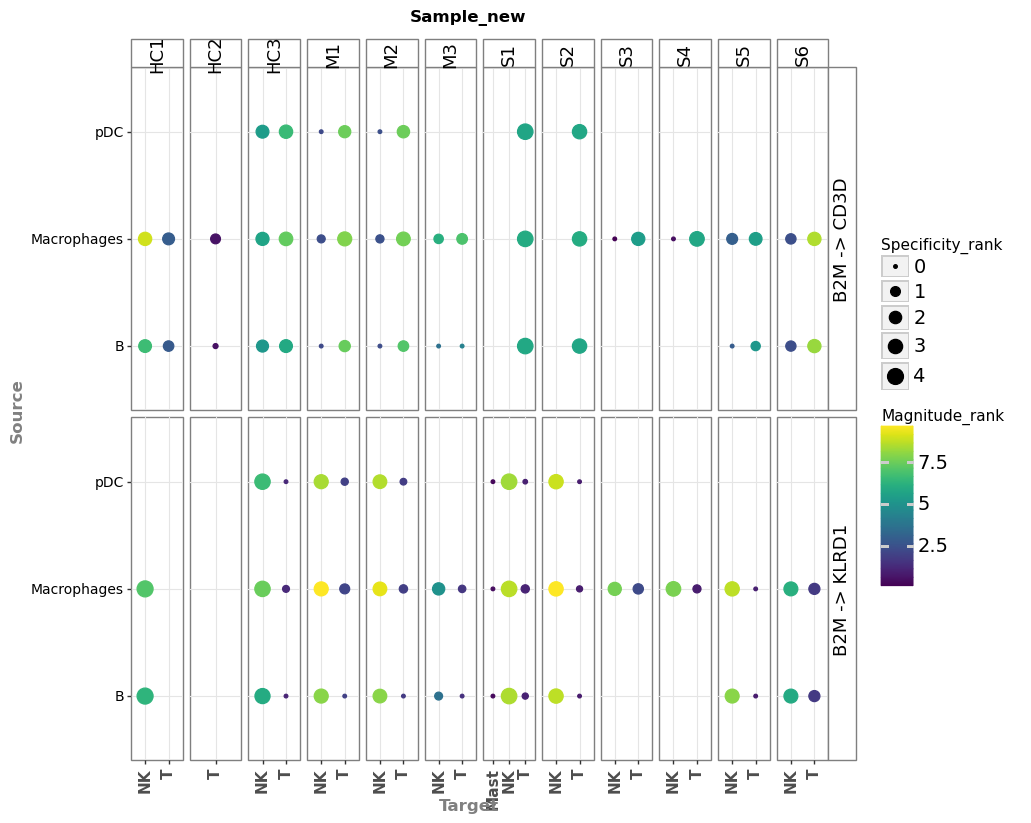

<ggplot: (8792640062594)>

In [18]:
li.pl.dotplot_by_sample(adata=adata,
                        colour='magnitude_rank',
                        size='specificity_rank',
                        source_labels=["B", "pDC", "Macrophages"],
                        target_labels=["T", "Mast", "pDC", "NK"],
                        ligand_complex = 'B2M',
                        receptor_complex= ['CD3D', 'KLRD1'],
                        sample_key='sample_new',
                        inverse_colour=True,
                        inverse_size=True,
                        figure_size=(9, 9),
                        size_range=(1, 6),
                        )

## 3) Generate Tensor

We can use Tensor-cell2cell to infer context-dependent CCC patterns from multiple samples simultaneously. To do so, we must first restructure the communication scores (LIANA's output) into a 4D-Communication Tensor. 

The tensor is built as follows: we create matrices with the communication scores for each of the ligand-receptor pairs within the same sample, then generate a 3D tensor for each sample, and finally concatenate them to form the 4D tensor:

![ccc-scores](https://github.com/earmingol/cell2cell/blob/master/docs/tutorials/ASD/figures/4d-tensor.png?raw=true)

The key parameters when building a tensor are:

- `inverse_fun` can pass a function to convert the communication score before using it to build the tensor. In this case, the `'magnitude_rank'` score generated by LIANA considers low values as the most important ones, ranging from 0 to 1. However, Tensor-cell2cell requires higher values to be the most important scores, so here we pass a function (`lambda x: 1 - x`) to adapt LIANA's magnitude-rank scores (substracts the LIANA's score from 1). If `None` is passed instead, no transformation will be performed on the communication score.


### <span style='color:red'> ^Erick's Note: I would include here only the inputs of the liana function. The parameters below this note are part of the supplementary section of the separate functions of cell2cell</span>

- `how` controls what ligand-receptor pairs and cell types to include when building the tensor. This decision is dependent on the number of samples including scores for their combinations of ligand-receptor and sender-receiver cell pairs. Options are:
    - `'inner'` is the more strict option since it only considers only cell types and LR pairs that are present in all contexts (intersection).
    - `'outer'` considers all cell types and LR pairs that are present across contexts (union).
    - `'outer_lrs'` considers only cell types that are present in all contexts (intersection), while all LR pairs that are present across contexts (union).
    - `'outer_cells'` considers only LR pairs that are present in all contexts (intersection), while all cell types that are present across contexts (union).

- `outer_fraction` is important to control the elements to include in the union scenario of the  `how` option. Only elements (cells/LRs) that are present at least this fraction of samples/contexts will be included. When this value is 0, considers all elements across the samples. When this value is 1, it is the same as setting `how='inner'`.

In [19]:
sorted_samples = sorted(adata.obs['sample_new'].unique()) # specify the order of the samples in the tensor

# build the tensor
tensor = li.multi.to_tensor_c2c(liana_res=adata.uns['liana_res'], # LIANA's dataframe containing results
                                sample_key='sample_new', # Column name of the samples
                                source_key='source', # Column name of the sender cells
                                target_key='target', # Column name of the receiver cells
                                ligand_key='ligand_complex', # Column name of the ligands
                                receptor_key='receptor_complex', # Column name of the receptors
                                score_key='magnitude_rank', # Column name of the communication scores to use
                                inverse_fun=lambda x: 1 - x, # Transformation function
                                how='outer', # What to include across all samples
                                outer_fraction=1/3., # Fraction of samples as threshold to include cells and LR pairs.
                                context_order=sorted_samples, # Order to store the contexts in the tensor
                               )

100%|███████████████████████████████████████████| 12/12 [00:19<00:00,  1.65s/it]


We can check the shape of this tensor to verify the number of samples, LR pairs, sender cells, adn receiver cells, respectively:

In [20]:
tensor.shape

torch.Size([12, 1054, 10, 10])

To interpret analysis on the tensor, we can map each sample/context to its respective context. This can also be done with LRs and cell types if hierarchical categories are available for those elements.

In [21]:
context_dict = adata.obs.sort_values(by='sample_new') \
                        .set_index('sample_new')['condition'] \
                        .to_dict()
dimensions_dict = [context_dict, None, None, None]
meta_tensor = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                              metadata_dicts=dimensions_dict,
                                              fill_with_order_elements=True
                                             )

We can export our tensor and its metadata:

In [22]:
c2c.io.export_variable_with_pickle(variable=tensor,
                                   filename=output_folder + '/Tensor.pkl')
c2c.io.export_variable_with_pickle(variable=meta_tensor,
                                   filename=output_folder + '/Tensor-Metadata.pkl')

../../data/quickstart/outputs/Tensor.pkl  was correctly saved.
../../data/quickstart/outputs/Tensor-Metadata.pkl  was correctly saved.


Then, we can load them with:

In [23]:
tensor = c2c.io.read_data.load_tensor(output_folder + '/Tensor.pkl')
meta_tensor = c2c.io.load_variable_with_pickle(output_folder + '/Tensor-Metadata.pkl')

## 04) Perform Tensor Factorization

Tensor-cell2cell can be run with a simple pipeline command that executes all important steps to perform the tensor factorization.


**Key parameters are:**

- `rank`  is the number of factors or latent patterns we want to obtain from the analysis. You can either indicate a specific number or leave it as `None` to perform the decomposition with a suggested number from an elbow analysis.

- `tf_optimization` indicates whether running the analysis in the `'regular'` or the `'robust'` way. The `'regular'` way runs the tensor decomposition less number of times than the robust way to select an optimal result. Additionally, the former employs less strict convergence parameters to obtain optimal results than the latter, which is also translated into a faster generation of results.

- `random_state` is the seed for randomization. It controls the randomization used when initializing the optimization algorithm that performs the tensor decomposition. It is useful for reproducing the same result every time that the analysis is run. If None, a different randomization will be used each time.


- `device` indicates whether we are using the `'cpu'` or a GPU with `'cuda'` cores.

Running Elbow Analysis


100%|███████████████████████████████████████████| 25/25 [33:21<00:00, 80.06s/it]


The rank at the elbow is: 11
Running Tensor Factorization


100%|█████████████████████████████████████████| 100/100 [05:44<00:00,  3.45s/it]


Best model has a normalized error of: 0.503
Generating Outputs
Loadings of the tensor factorization were successfully saved into ../../data/quickstart/outputs/Loadings.xlsx


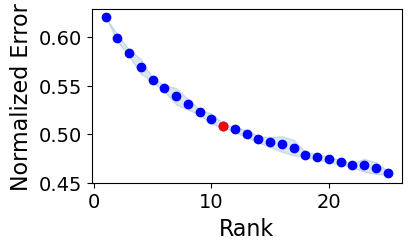

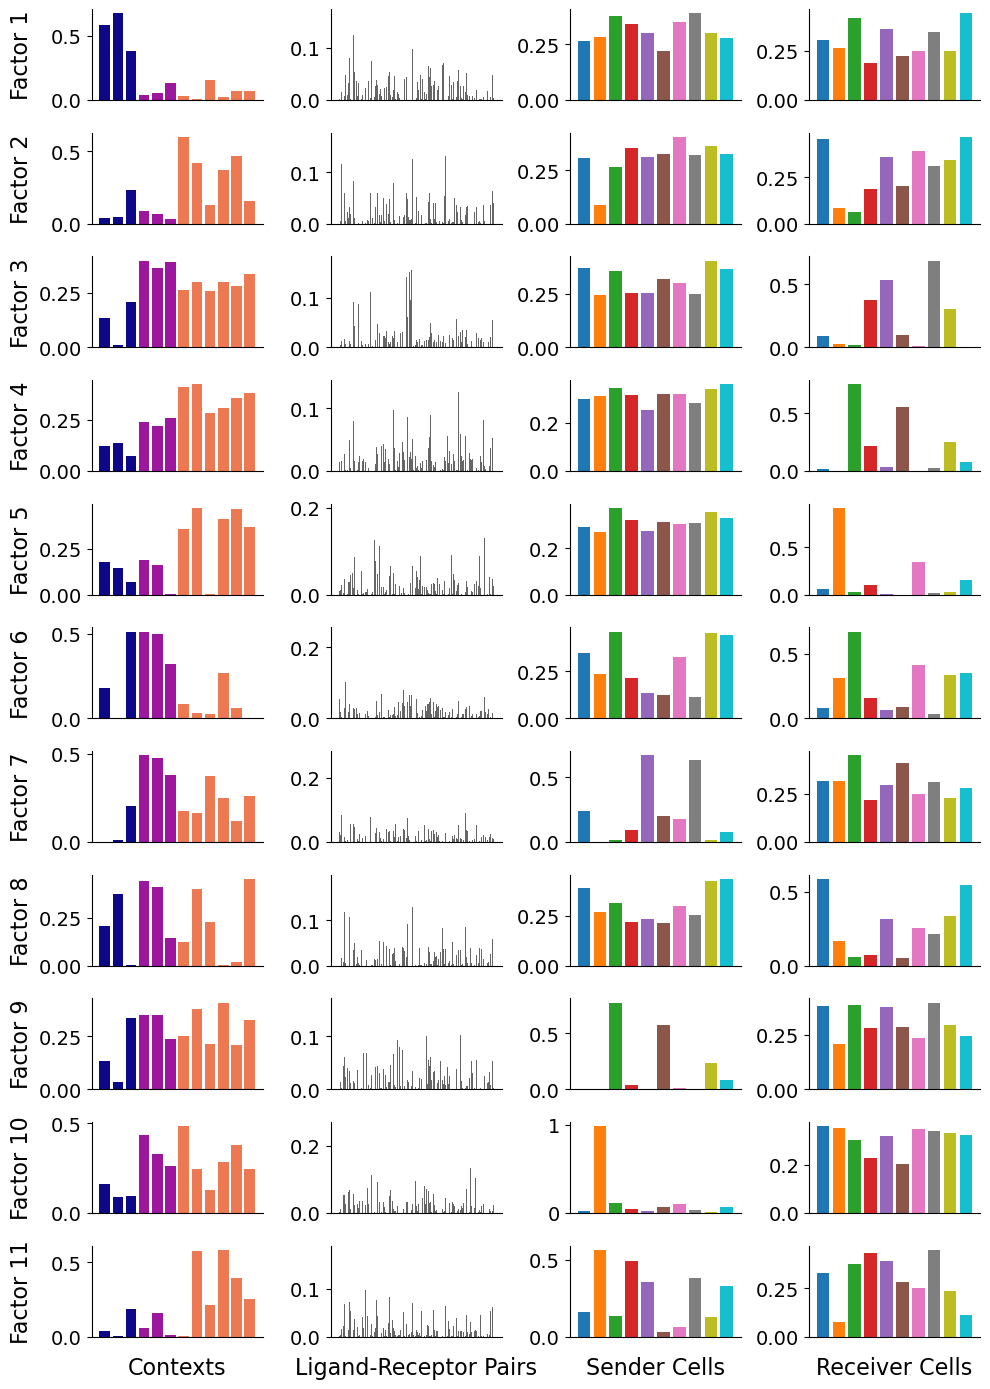

In [24]:
c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                           meta_tensor,
                                           rank=None, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis
                                           tf_optimization='robust', # To define how robust we want the analysis to be.
                                           random_state=0, # Random seed for reproducibility
                                           device='cuda', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                           output_folder=output_folder, # Whether to save the figures in files. If so, a folder pathname must be passed
                                            )

 <span style='color:red'> I would say some of the supplement in Tutorial 04 discussing what a factor is (more on the conceptual side) should be moved here. Not adding the note there for now since Daniel is working on the main branch
    
Each factor represents distinct combinations of ligand-receptor interactions as well as cell types participating in cell-cell communication among the different COVID-19 severities. <span style='color:red'> <--from tutorial 05 boxplot

### Factorization Results

After running the decomposition, the results are stored in the `factors` attribute of the tensor object. This attribute is a dictionary containing the loadings for each of the elements in every tensor dimension. Loadings delineate the importance of that particular element to that factor. Keys are the names of the different dimension.

In [25]:
tensor.factors.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

We can inspect the loadings of the samples, for example, located under the key `'Contexts'`:

In [26]:
tensor.factors['Contexts']

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11
HC1,0.581870,0.040361,0.131953,0.119806,0.178544,0.181279,0.000131,0.208503,0.132697,0.159241,0.037401
HC2,0.675940,0.049364,0.009344,0.133802,0.145120,0.000663,0.008695,0.373337,0.035970,0.088163,0.000521
HC3,0.381718,0.229167,0.206034,0.073976,0.066703,0.513675,0.204721,0.002981,0.334320,0.093064,0.184269
M1,0.039182,0.087081,0.395480,0.238517,0.187059,0.514026,0.491986,0.442298,0.348291,0.434499,0.054793
M2,0.052430,0.068177,0.363611,0.216768,0.161489,0.500788,0.475657,0.410282,0.350431,0.327826,0.156475
M3,0.132346,0.029249,0.389527,0.257464,0.001954,0.322589,0.381611,0.146320,0.236175,0.264326,0.011185
S1,0.034546,0.598237,0.259607,0.408108,0.358279,0.083866,0.175383,0.120909,0.253131,0.484017,0.000726
S2,0.004635,0.419753,0.296984,0.421941,0.473268,0.029877,0.164295,0.398711,0.379040,0.242650,0.575086
S3,0.157778,0.130115,0.257357,0.283514,0.001802,0.027778,0.375685,0.229450,0.213406,0.130352,0.210583
S4,0.020355,0.373493,0.298470,0.307374,0.413053,0.267518,0.249876,0.004026,0.408326,0.281932,0.582762


## 05) Downstream Visualizations

<span style='color:red'>I chose a few of the visualizations for now, but we may want to include/exclude others</span>

We can statistically compare the loadings between contexts for each factor to see how the factors are associated with context:

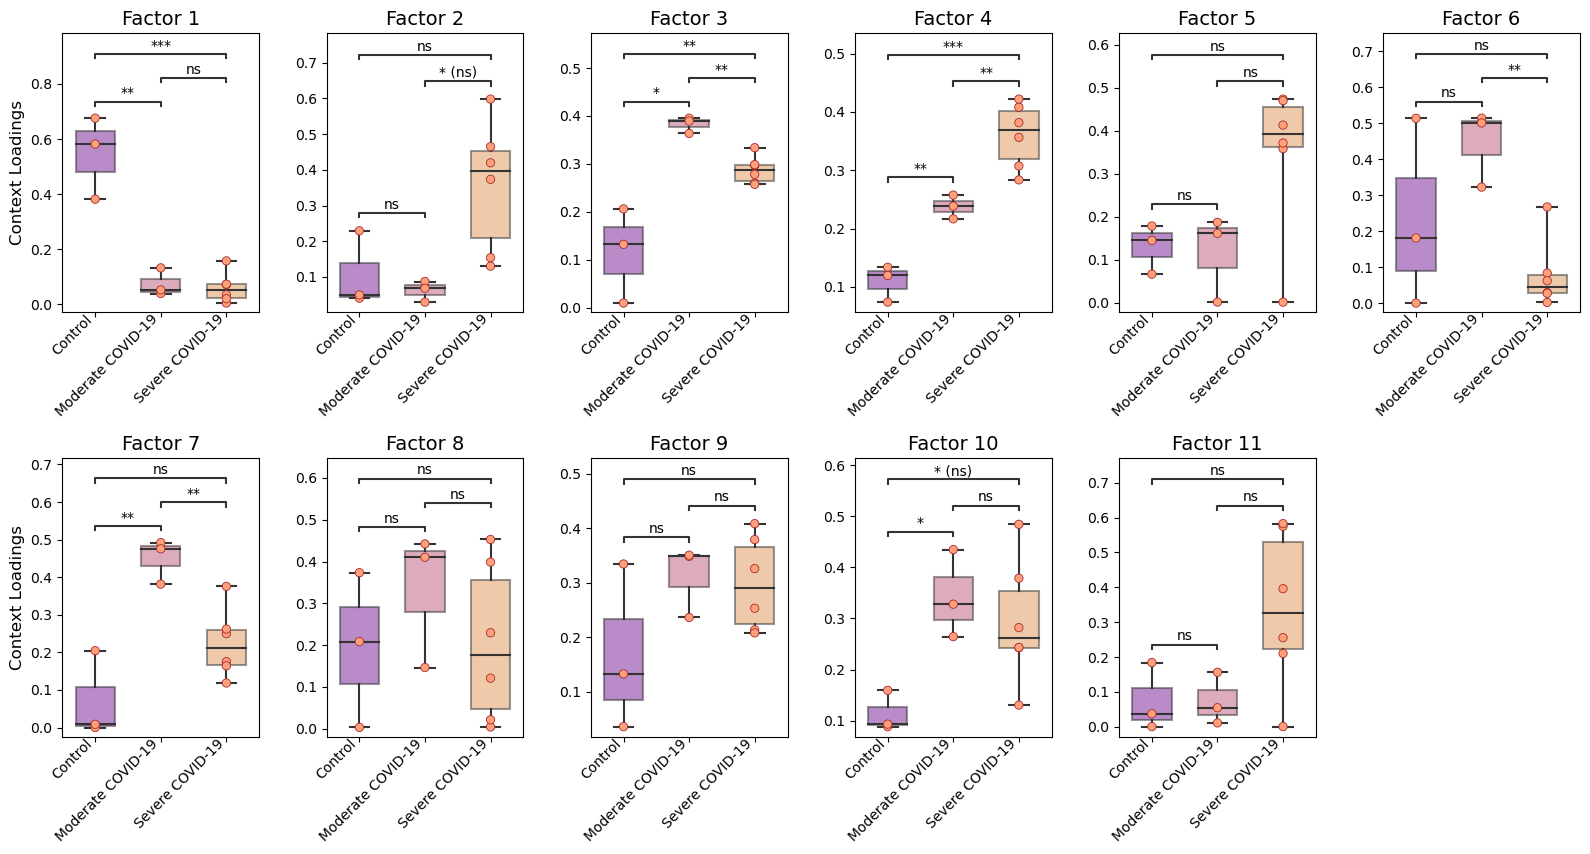

In [27]:
groups_order = ['Control', 'Moderate COVID-19', 'Severe COVID-19']
fig_filename = output_folder + '/BALF-Severity-Boxplots.pdf'

_ = c2c.plotting.context_boxplot(context_loadings=tensor.factors['Contexts'],
                                 metadict=context_dict,
                                 nrows=2,
                                 figsize=(16, 9),
                                 group_order=groups_order,
                                 statistical_test='t-test_ind',
                                 pval_correction='fdr_bh',
                                 cmap='plasma',
                                 verbose=False, 
                                 filename=fig_filename
                                )

We can also cluster these samples/contexts by the factors:

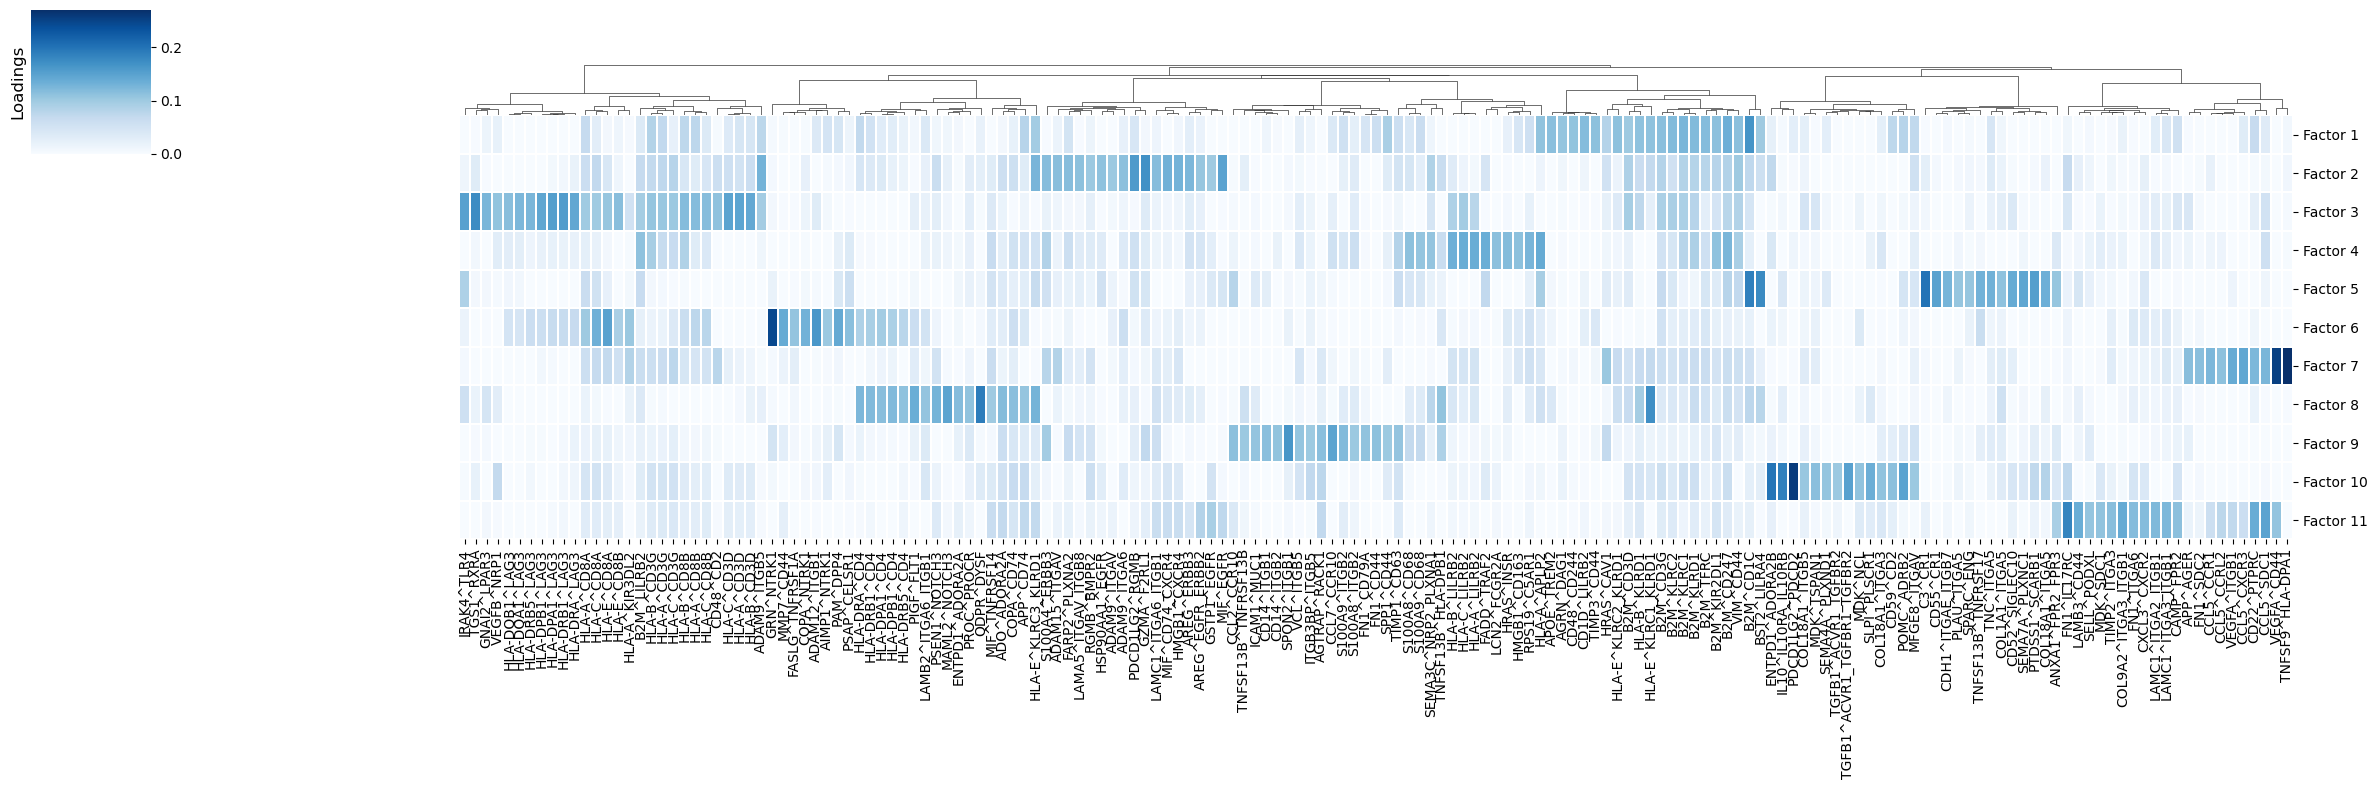

In [28]:
fig_filename = output_folder + '/Clustermap-LRs.pdf'

_ = c2c.plotting.loading_clustermap(loadings=tensor.factors['Ligand-Receptor Pairs'],
                                    loading_threshold=0.1,
                                    use_zscore=False,
                                    figsize=(24, 8),
                                    filename=fig_filename,
                                    row_cluster=False
                                   )

Here patients are grouped by the importance that each communication pattern (factor) has in relation to the other patients. This captures combinations of related communication patterns that explain similarities and differences at a sample-specific resolution. In this case the differences are reflected with an almost perfect clustering by COVID-19 severity, where moderate cases are more similar to control cases.

## 06) Functional Footprinting

### Pathway Enrichment of LR loadings

As the number of inferred interactions increases, the interpretation of the inferred cell-cell communication networks becomes more challenging. To this end, we can perform pathway enrichment analysis to identify the general biological processes that are enriched in the inferred interactions. Here, we will perform classical gene set enrichment analysis with `KEGG Pathways`.

In [29]:
lr_loadings = tensor.factors['Ligand-Receptor Pairs']

# Generate list with ligand-receptors pairs in DB
lr_list = ['^'.join(row) for idx, row in lr_pairs.iterrows()]

# Specify the organism and pathway database to use for building the LR set
organism = "human"
pathwaydb = "KEGG"

# Generate ligand-receptor gene sets
lr_set = c2c.external.generate_lr_geneset(lr_list,
                                          complex_sep='_',
                                          lr_sep='^',
                                          organism=organism,
                                          pathwaydb=pathwaydb,
                                          readable_name=True
                                          )

Next, we can perform enrichment analysis on each factor using the loadings of the ligand-receptor pairs:

In [30]:
pvals, scores, gsea_df = c2c.external.run_gsea(loadings=lr_loadings,
                                               lr_set=lr_set,
                                               output_folder=output_folder,
                                               weight=1,
                                               min_size=15,
                                               permutations=999,
                                               processes=6,
                                               random_state=6,
                                               significance_threshold=0.05,
                                              )

../../data/quickstart/outputs already exists.


 18%|████████                                    | 2/11 [00:01<00:05,  1.73it/s]2023-03-17 16:25:03,545 [WARNING] Duplicated values found in preranked stats: 0.28% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 27%|████████████                                | 3/11 [00:03<00:11,  1.44s/it]2023-03-17 16:25:06,007 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 36%|████████████████                            | 4/11 [00:04<00:08,  1.18s/it]2023-03-17 16:25:06,847 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
 73%|████████████████████████████████            | 8/11 [00:09<00:04,  1.34s/it]2023-03-17 16:25:12,083 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce 

The enriched pathways are for each factor are:

In [31]:
gsea_df.loc[(gsea_df['Adj. P-value'] <= 0.05) & (gsea_df['NES'] > 0.)]

,Factor,Term,NES,P-value,Adj. P-value
13,Factor 3,ANTIGEN PROCESSING AND PRESENTATION,1.441494,0.001000,0.018590
52,Factor 6,ANTIGEN PROCESSING AND PRESENTATION,1.615916,0.001000,0.018590
53,Factor 6,CELL ADHESION MOLECULES CAMS,1.547076,0.001000,0.018590
65,Factor 7,ANTIGEN PROCESSING AND PRESENTATION,1.537889,0.001000,0.018590
78,Factor 8,INTESTINAL IMMUNE NETWORK FOR IGA PRODUCTION,1.368692,0.003006,0.048848
79,Factor 8,ANTIGEN PROCESSING AND PRESENTATION,1.299828,0.001001,0.018590


The depleted pathways are:

In [32]:
gsea_df.loc[(gsea_df['Adj. P-value'] <= 0.05) & (gsea_df['NES'] < 0.)]

,Factor,Term,NES,P-value,Adj. P-value
17,Factor 3,APOPTOSIS,-1.062030,0.001,0.01859
120,Factor 11,APOPTOSIS,-1.132762,0.001,0.01859


Finally, we can visualize the enrichment results using a dotplot:

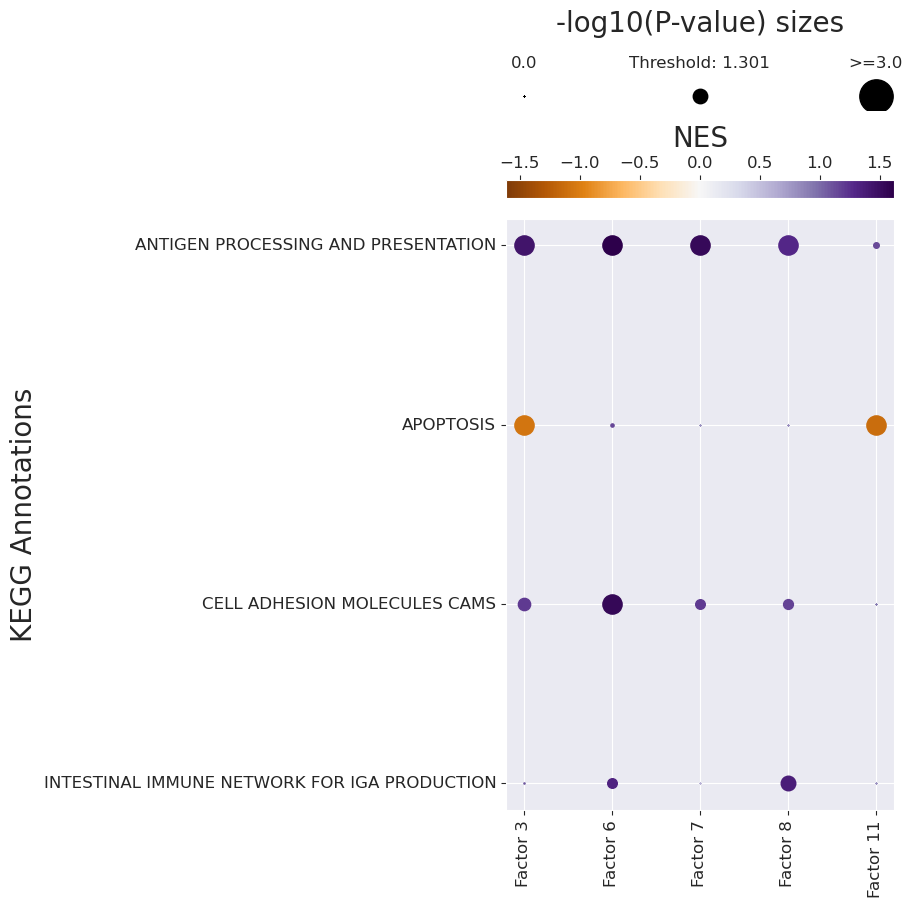

In [33]:
pathway_label = '{} Annotations'.format(pathwaydb)
fig_filename = output_folder + '/GSEA-Dotplot.pdf'

with sns.axes_style("darkgrid"):
    dotplot = c2c.plotting.pval_plot.generate_dot_plot(pval_df=pvals,
                                                      score_df=scores,
                                                      significance=0.05,
                                                      xlabel='',
                                                      ylabel='{} Annotations'.format(pathwaydb),
                                                      cbar_title='NES',
                                                      cmap='PuOr',
                                                      figsize=(5, 10),
                                                      label_size=20,
                                                      title_size=20,
                                                      tick_size=12,
                                                      filename=fig_filename
                                                      )

### Footprint Enrichment

Footprint enrichment analysis build upon classic geneset enrichment analysis, as instead of considering the genes involved in a biological activity, they consider the genes affected by the activity, or in other words the genes that change downstream of said activity [(Dugourd and Saez-Rodriguez, 2019)](https://www.sciencedirect.com/science/article/pii/S2452310019300149). 

In this case, we will use the PROGENy pathway resource to perform footprint enrichment analysis. PROGENy was built in a data-driven manner using perturbation and cancer lineage data [(Schubert et al, 2019)](https://www.nature.com/articles/s41467-017-02391-6#Sec8), as a consequence it also assigns different importances or weights to each gene in its pathway genesets.To this end, we need an enrichment method that can take weights into account, and here we will use multi-variate linear models from the `decoupler-py` package to perform this analysis [(Badia-i-Mompel et al., 2022)](https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613).

First, we load and format the PROGENy resource:

In [34]:
# We first load the PROGENy gene sets
net = dc.get_progeny(organism='human', top=5000)

# Then convert them to sets with weighed ligand-receptor pairs
lr_progeny = li.funcomics.generate_lr_geneset(lr_pairs, net, lr_separator="^")

Next, we can run the footprint enrichment analysis:

In [35]:
estimate, pvals =  dc.run_mlm(lr_loadings.transpose(), 
                              lr_progeny, 
                              source="source", 
                              target="interaction", 
                              use_raw=False)

Finally, we can visualize the results:

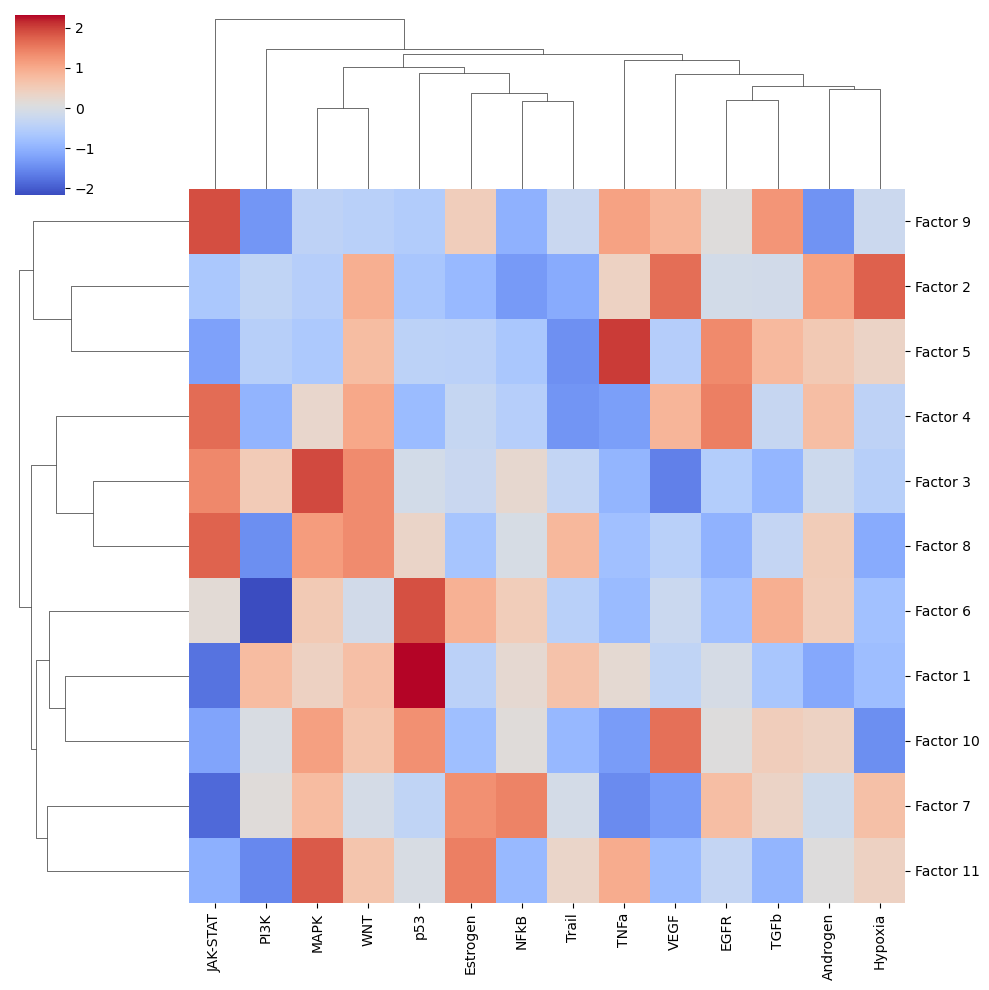

In [36]:
fig_filename = output_folder + '/PROGENy.pdf'
_ = sns.clustermap(estimate, xticklabels=estimate.columns, cmap='coolwarm', z_score=4)
plt.savefig(fig_filename, dpi=300, bbox_inches='tight')

Let's zoom in on Factor <span style='color:red'>**XXX**</span>, which is associated with COVID-19 cases. 

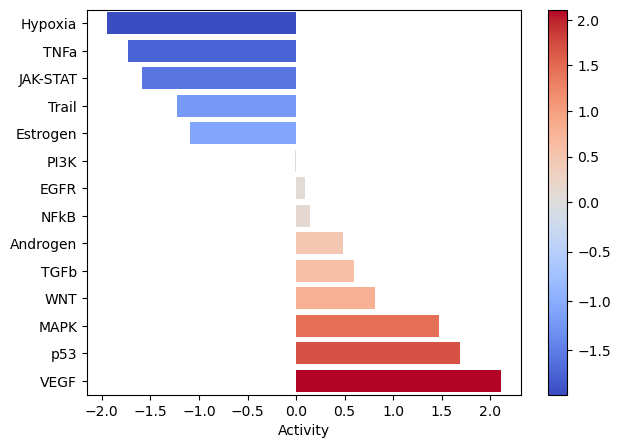

In [37]:
selected_factor = 'Factor 10'
fig_filename = output_folder + '/PROGENy-{}.pdf'.format(selected_factor.replace(' ', '-'))

dc.plot_barplot(estimate,
                selected_factor,
                vertical=True, 
                cmap='coolwarm', 
                save=fig_filename)